In [ ]:
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2020-12-13 09:36:10--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  25.9MB/s    in 2m 31s  

2020-12-13 09:38:41 (14.8 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

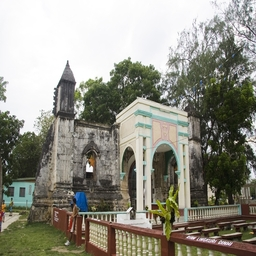

In [ ]:
from IPython.display import Image, display
display(Image(filename='images/train/class/84b3ccd8209a4db1835988d28adfed4c.jpg'))

In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

     |████████████████████████████████| 5.7MB 7.1MB/s 
     |████████████████████████████████| 112kB 43.5MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=27725f491c5bb7d22c229b1bd70bcdba5a2aedb88cfb6e12fd42a105706672dc
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()


In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 20

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls '/content/gdrive/'


MyDrive/


In [ ]:
ls gdrive/MyDrive

In [ ]:
ep10_weights = torch.load('/content/gdrive/MyDrive/best-model-epoch-10-losses-0.003.pth', map_location=lambda storage, loc: storage)

In [ ]:
model.load_state_dict(ep10_weights)

<All keys matched successfully>

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), '/content/gdrive/My Drive/best-model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1+10,losses))
  if epoch%10 == 0 and epoch >0:
    print(epoch," is reached\n")
    torch.save(model.state_dict(), '/content/gdrive/My Drive/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1+10,losses))


Starting training epoch 0
Epoch: [0][0/625]	Time 1.507 (1.507)	Data 1.395 (1.395)	Loss 0.0026 (0.0026)	
Epoch: [0][25/625]	Time 1.299 (1.319)	Data 1.257 (1.274)	Loss 0.0023 (0.0028)	
Epoch: [0][50/625]	Time 1.280 (1.312)	Data 1.239 (1.268)	Loss 0.0028 (0.0028)	
Epoch: [0][75/625]	Time 1.350 (1.317)	Data 1.308 (1.274)	Loss 0.0030 (0.0029)	
Epoch: [0][100/625]	Time 1.296 (1.315)	Data 1.254 (1.273)	Loss 0.0026 (0.0028)	
Epoch: [0][125/625]	Time 1.277 (1.311)	Data 1.235 (1.269)	Loss 0.0025 (0.0028)	
Epoch: [0][150/625]	Time 1.273 (1.309)	Data 1.231 (1.267)	Loss 0.0032 (0.0028)	
Epoch: [0][175/625]	Time 1.280 (1.304)	Data 1.238 (1.261)	Loss 0.0030 (0.0028)	
Epoch: [0][200/625]	Time 1.307 (1.301)	Data 1.266 (1.259)	Loss 0.0027 (0.0028)	
Epoch: [0][225/625]	Time 1.288 (1.301)	Data 1.246 (1.258)	Loss 0.0032 (0.0028)	
Epoch: [0][250/625]	Time 1.376 (1.301)	Data 1.334 (1.259)	Loss 0.0028 (0.0028)	
Epoch: [0][275/625]	Time 1.386 (1.303)	Data 1.344 (1.261)	Loss 0.0035 (0.0028)	
Epoch: [0][300/625]

<Figure size 432x288 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/model-final-model-losses-{:.3f}.pth'.format(losses))

In [ ]:
import PIL
im = PIL.Image.open('images/train/class/84b3ccd8209a4db1835988d28adfed4c.jpg')

In [ ]:
# img_p = torch.from_numpy(np.asarray(val_transforms(im)).unsqueeze(0).float()
pim = torch.from_numpy(rgb2gray(np.asarray(val_transforms(im)))).unsqueeze(0).float()

In [ ]:
model.eval()
pm = model(pim.unsqueeze(0).cuda())

In [ ]:
save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
save_name = 'imgcra.jpg'
mm = torch.cat((pim, pm.squeeze(0).cpu()), 0).detach().numpy()
# pim.shape
# pm.squeeze(0).shape

In [ ]:
  mm = mm.transpose((1, 2, 0))  # rescale for matplotlib
  mm[:, :, 0:1] = mm[:, :, 0:1] * 100
  mm[:, :, 1:3] = mm[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(mm.astype(np.float64))

In [ ]:
plt.imsave(arr=color_image, fname='temp.png')

In [ ]:
validate(val_loader, model, criterion, save_images, 0)

Validate: [0/16]	Time 1.496 (1.496)	Loss 0.0024 (0.0024)	
Finished validation.


0.0027876743245869875

<Figure size 432x288 with 0 Axes>